## **Predict churn**

---
1. Explore churner metrics dataset
2. Build and evaluate logistic regression
3. Build and evaluate XGBoost


In [121]:
# @title
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier

In [122]:
# @title
# Load churner metrics dataset

metrics_filepath = f"/content/drive/MyDrive/livebook_churn_prediction/test_updated_churner_metrics.csv"
data = pd.read_csv(metrics_filepath)


---

### **Explore churner metrics dataset**
- About the data
- Is the dataset imbalanced?

In [3]:
data.shape

(32931, 16)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32931 entries, 0 to 32930
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   is_churn                      32931 non-null  int64  
 1   total_events                  32931 non-null  int64  
 2   uniq_prod_ct                  32931 non-null  int64  
 3   total_freebies                32931 non-null  int64  
 4   pct_reading                   32931 non-null  float64
 5   pct_downloads_per_book        32931 non-null  float64
 6   readingownedbook              32931 non-null  int64  
 7   ebookdownloaded               32931 non-null  int64  
 8   readingfreepreview            32931 non-null  int64  
 9   highlightcreated              32931 non-null  int64  
 10  freecontentcheckout           32931 non-null  int64  
 11  readingopenchapter            32931 non-null  int64  
 12  producttoclivebooklinkopened  32931 non-null  int64  
 13  l


---

**About the data**

The behavioural metrics dataset for customers who churned (i.e. purchased a book) in Q2 describes 32,931 liveBook customers and has 16 columns, two of which will be dropped in preparation for the train-validation-test splits required in the modelling tasks below.
- `account_id` is unique for every customer, so it does not provide any meaningful information for churn prediction.
- `observation_date` has one unique value and thereby does not provide any meaningful information for churn prediction.

Of the 16 columns, the 15 features are continuous and the target, boolean. Per the nature of binary classfication tasks, the target must be converted to binary before we proceed to any model-specific data preparation.

In [15]:
data = data.drop(['account_id', 'observation_date'], axis=1).copy()
data['is_churn'] = data['is_churn'].astype(int)


---

**Is the dataset imbalanced?**

Recall that our target is the only categorical variable. So, to evaluate the class balance throughout the data, we only need to consider `is_churn`. From previous analyses, we calculated a 69 percent churn rate, meaning that 69 percent of the `is_churn` column is 1s or churners, leaving 39 percent of the column as 0s or retained customers. Therefore, the ratio of classes in `is_churn` is 13:23 (0:1).

According to [Google for Developers Foundational Machine Learning course](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data#:~:text=A%20classification%20data%20set%20with,smaller%20proportion%20are%20minority%20classes), the dataset is mildly imbalanced (minority class comprises 20-40 percent of the data). Though this should not affect prediction too badly, we might consider random oversampling and undersampling further along to achieve greater balance in the classes.

In [123]:
data['is_churn'].value_counts()

True     22749
False    10182
Name: is_churn, dtype: int64


---

### **Approach 1: Logistic Regression**

1. [Prepare data](https://colab.research.google.com/drive/1pvmaAiXVk_rx5GPNs6Xu8SokOQAHEs1v#scrollTo=db-yshtqjIt-&line=4&uniqifier=1)
2. Split data into train, validation, and test sets (80:10:10)
3. Get baseline and evaluate by the appropriate metric
4. Fit logistic regression classifier using training set
5. Tune hyperparameters using validation set
6. Evaluate the model using the test set


---

#### **1. Prepare data**

To prepare the customer behaviour metrics for logistic regression, we will first assess the data for the following assumptions of binary logistic regression:
  1. Binary target
  2. Remove outliers
  3. Linearity between each feature and the log-odds of the target
  4. Minimal multicollinearity

[Source 1](https://machinelearningmastery.com/logistic-regression-for-machine-learning/), [Source 2](https://www.youtube.com/watch?v=nmB1XG18Xys&ab_channel=MarinStatsLectures-RProgramming%26Statistics)


---

**Linearity check**

We will quantize each customer behaviour metric and compute the probability of churn in each quartile. Using these probabilities, we will calculate the logits for the y-axis of the log-odds plot. For the x-axis, the metric's medians will be calculated per quartile as well. By plotting the log-odds, we should be able to graphically assess the linearity between each feature and the log-odds of churn.

Preferably, the Box-Tidwell test could have been conducted more easily and efficiently, though it does not presently exist in any Python package or framework.

[Source](https://www.youtube.com/watch?v=5TW_wWeTOe0&ab_channel=MarinStatsLectures-RProgramming%26Statistics)

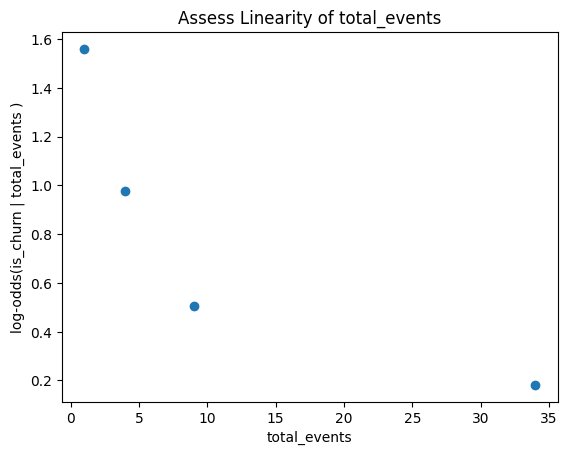

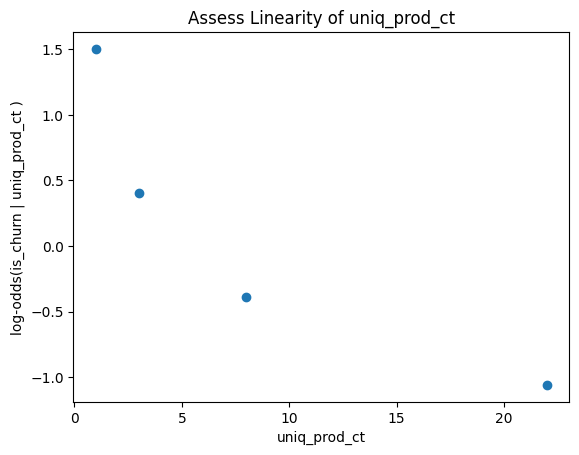

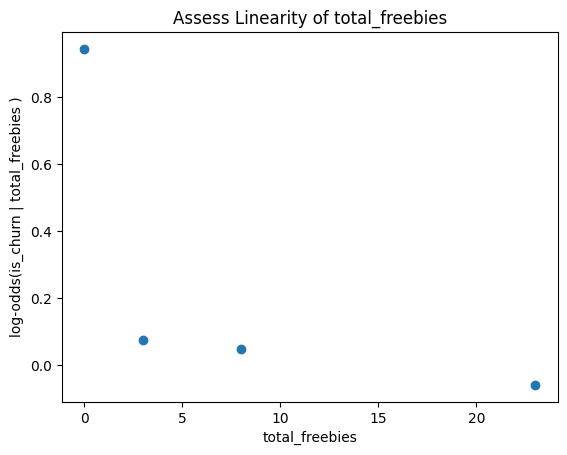

<ipython-input-120-d9a7a4b2150a>:26: RuntimeWarning: divide by zero encountered in log
  logits = [np.log(prob/(1-prob)) for prob in probs]


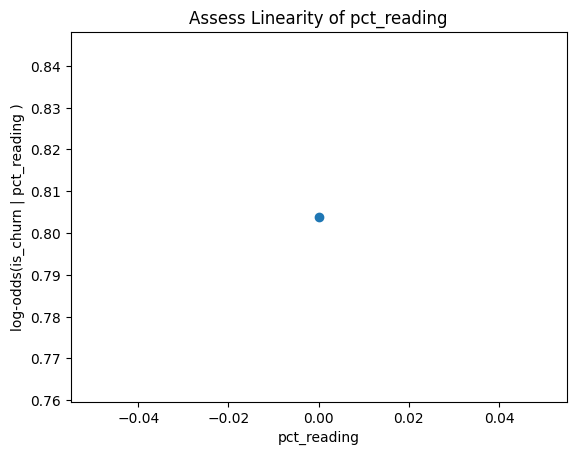

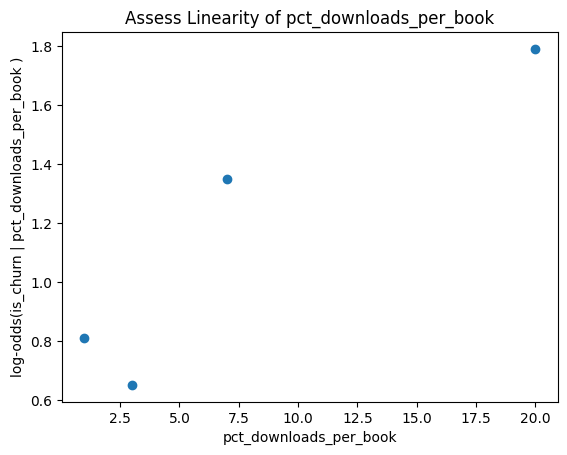

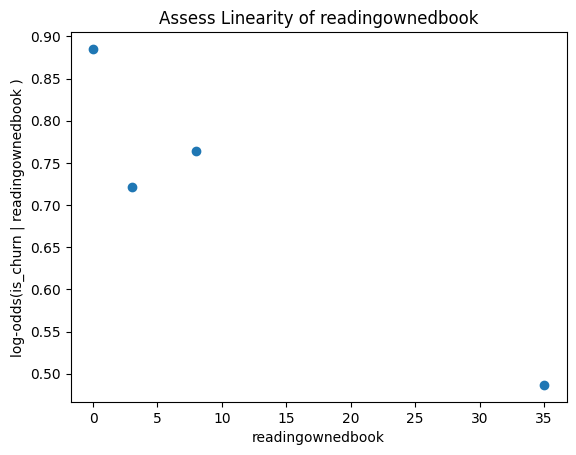

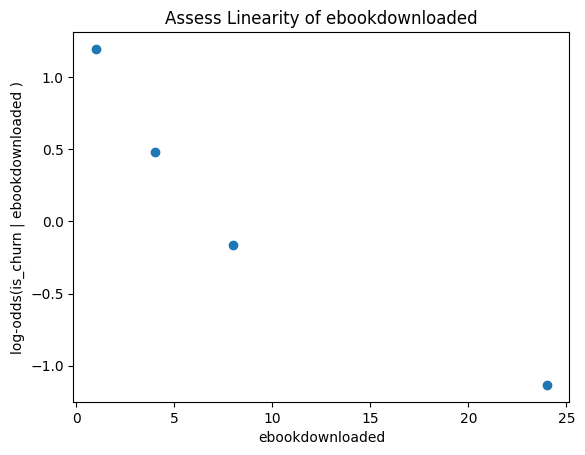

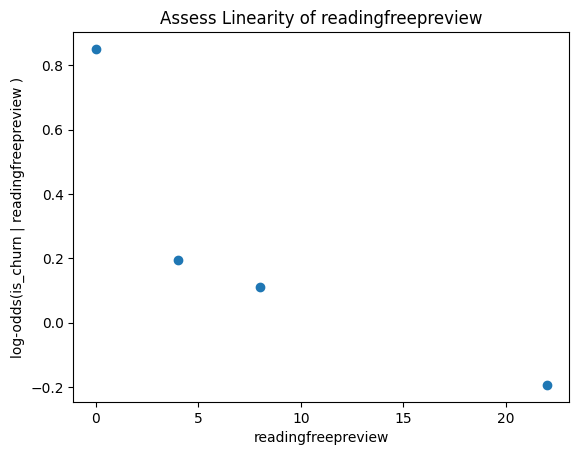

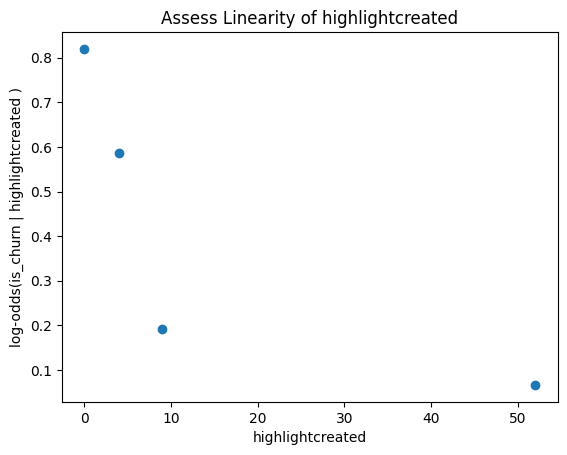

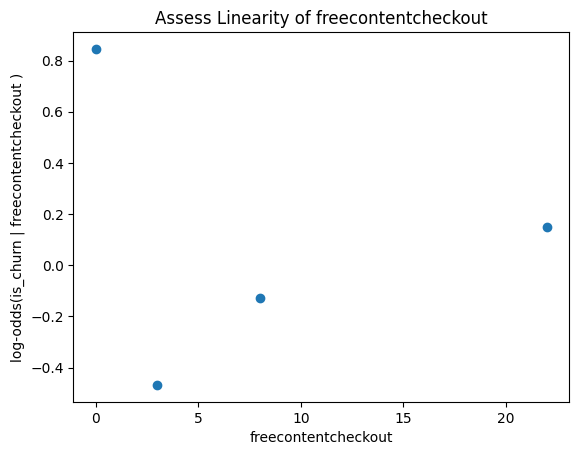

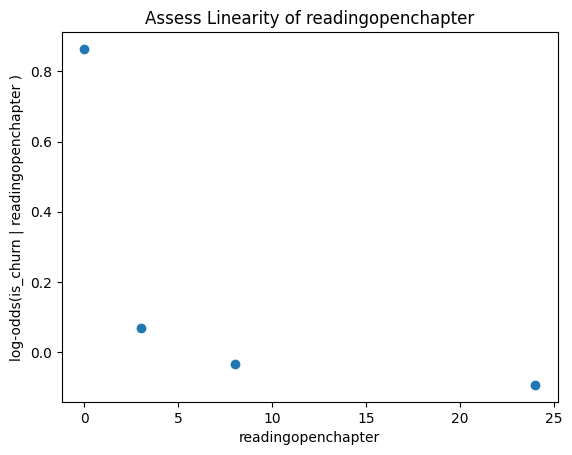

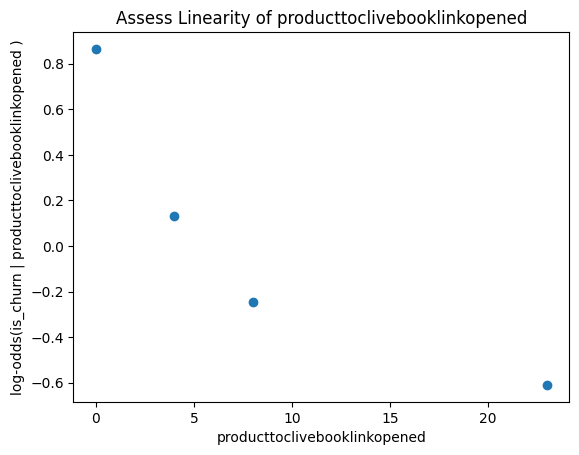

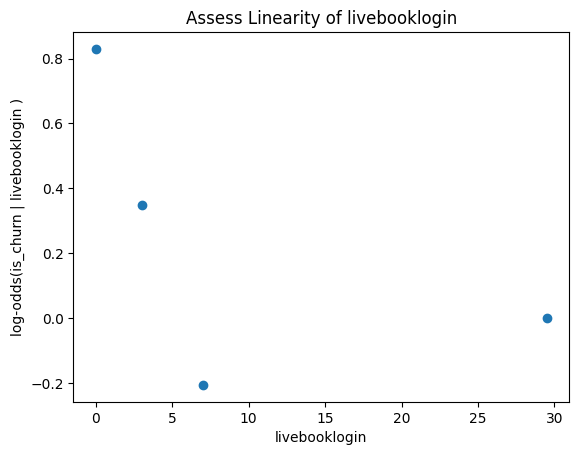

In [120]:
# @title
features = data.columns.tolist()

def compute_quartile_probs(feature):
  p_q1 = data['is_churn'][data[feature] <= quartiles[1]].mean()
  p_q2 = data['is_churn'][(data[feature] > quartiles[1]) & (data[feature] <= quartiles[2])].mean()
  p_q3 = data['is_churn'][(data[feature] > quartiles[2]) & (data[feature] <= quartiles[3])].mean()
  p_q4 = data['is_churn'][data[feature] > quartiles[3]].mean()
  probs = [p_q1, p_q2, p_q3, p_q4]
  probs = [np.nan_to_num(prob) for prob in probs]
  return probs

def compute_quartile_midpts(feature):
  mp_q1 = data[feature][data[feature] <= quartiles[1]].median()
  mp_q2 = data[feature][(data[feature] > quartiles[1]) & (data[feature] <= quartiles[2])].median()
  mp_q3 = data[feature][(data[feature] > quartiles[2]) & (data[feature] <= quartiles[3])].median()
  mp_q4 = data[feature][data[feature] > quartiles[3]].median()
  midpts = [mp_q1, mp_q2, mp_q3, mp_q4]
  return midpts

def check_linearity(feature):
  quartiles = data[feature].describe()[3: ]
  probs = compute_quartile_probs(feature)
  midpts = compute_quartile_midpts(feature)
  logits = [np.log(prob/(1-prob)) for prob in probs]
  plt.scatter(midpts, logits)
  plt.title(f"Assess Linearity of {feature}")
  plt.xlabel(feature)
  plt.ylabel(f"log-odds(is_churn | {feature} )")
  plt.show()

In [ ]:
for feature in features:
  if feature == 'is_churn':
    continue
  else:
    check_linearity(feature)

`freecontentcheckout` and `livebooklogin`


---

**Mulicollinearity assumption**

We will set the correlation threshold to 0.5, meaning that any metrics with correlation coefficients > 0.5 will be dropped.
- livebook and total_events
- producttoclivebooklinkopened and total_events
- total_freebies and uniq_prod_ct
- ebookdownloaded and uniq_prod_ct
- freecontentcheckout and uniq_prod_ct
- readingfreepreview and totalfreebies
-

In [140]:
data.iloc[:, 3:].corr(numeric_only=True)

,total_events,uniq_prod_ct,total_freebies,pct_reading,pct_downloads_per_book,readingownedbook,ebookdownloaded,readingfreepreview,highlightcreated,freecontentcheckout,readingopenchapter,producttoclivebooklinkopened,livebooklogin
total_events,1.000000,0.345961,0.476824,0.085533,-0.052449,0.472445,0.192733,0.319122,0.415743,0.431351,0.378450,0.772537,0.549548
uniq_prod_ct,0.345961,1.000000,0.509178,-0.036665,-0.040371,0.269940,0.736861,0.344680,0.166894,0.502210,0.382992,0.026697,0.387951
total_freebies,0.476824,0.509178,1.000000,0.003495,-0.096000,0.309006,0.207662,0.706974,0.277905,0.636126,0.895242,0.045624,0.638726
pct_reading,0.085533,-0.036665,0.003495,1.000000,-0.433419,0.411695,-0.162704,0.020361,0.004827,-0.035421,0.010376,-0.002490,0.162672
pct_downloads_per_book,-0.052449,-0.040371,-0.096000,-0.433419,1.000000,-0.185461,0.278889,-0.103009,-0.038325,-0.048748,-0.072071,-0.008472,-0.113805
readingownedbook,0.472445,0.269940,0.309006,0.411695,-0.185461,1.000000,0.043828,0.262954,0.307869,0.204332,0.248413,0.082039,0.466623
ebookdownloaded,0.192733,0.736861,0.207662,-0.162704,0.278889,0.043828,1.000000,0.101105,0.072105,0.269234,0.148712,0.009502,0.165825
readingfreepreview,0.319122,0.344680,0.706974,0.020361,-0.103009,0.262954,0.101105,1.000000,0.137974,0.293176,0.426865,0.050347,0.404559
highlightcreated,0.415743,0.166894,0.277905,0.004827,-0.038325,0.307869,0.072105,0.137974,1.000000,0.260645,0.242990,0.014721,0.375253
freecontentcheckout,0.431351,0.502210,0.636126,-0.035421,-0.048748,0.204332,0.269234,0.293176,0.260645,1.000000,0.384779,0.036456,0.644018



---

#### **2. Split data into train, validation, and test sets (80:10:10)**

In [6]:
X = data.drop(['is_churn'], axis=1).copy()
y = data['is_churn'].copy()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8, stratify=y)
# X_val, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=8, stratify=y)


---

#### **3. Evaluate baseline by the appropriate metric**

The baseline is predicting that every customer in the test set has churned (majority class).

In [ ]:
accuracy_score(y, np.ones_like(y)), roc_auc_score(y, np.ones_like(y))


---

#### **4. Fit logistic regression classifier using training set**


---

#### **5. Tune hyperparameters using validation set**


---

#### **6. Evaluate the model using the test set**


---

### **Approach 2: XGBoost**
1. Build and evaluate preliminary XGBoost model
2. Compare to baseline
3. Optimize parameters using `GridSearchCV()`




---

#### **Build preliminary XGBoost model**
Recall that the churn rate is 69 percent, meaning that 69 percent of the customers in the behaviour metrics dataset have a 1-value in the `is_churn` column. This tells us that the data is imbalanced. Therefore, when we split the data into training and testing sets, we will use stratification to maintain the same percentage of people who left the company in both training and testing sets.

In [ ]:
y.value_counts() # Slight class imbalance; we can stratify

1    22749
0    10182
Name: is_churn, dtype: int64

In [ ]:
sum(y)/len(y)

0.69080805320215

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=8, stratify=y)

In [ ]:
sum(y_train)/len(y_train)

0.6908214394169451

In [ ]:
sum(y_val)/len(y_val)

0.6907545164718385

In [ ]:
len(y_val)

6587

In [ ]:
clf_xgb = XGBClassifier(objective='binary:logistic', seed=8)
clf_xgb.fit(
    X_train,
    y_train,
    verbose=False,
    early_stopping_rounds=10,
    eval_metric='logloss',
    eval_set=[(X_val, y_val)])

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


KeyboardInterrupt: ignored

In [ ]:
y_pred = clf_xgb.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Retained', 'Churned']).plot(cmap='Blues')

In [ ]:
y_pred = clf_xgb.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Retained', 'Churned']).plot(cmap='Blues')

Misclassifying churners as retained customers is costlier than misclassifying retained customers as churned.

In [ ]:
def clf_report(cm):
  tn, fp, fn, tp = cm.ravel()
  sensitivity = tp/(tp+fn)
  specificity = tn/(tn+fp)
  precision = tp/(tp+fp)
  neg_pred_val = tn/(tn+fn)
  accuracy = (tp+tn)/(tp+tn+fp+fn)
  print(f'Sensitivity: {sensitivity}\nSpecificity: {specificity}\nPrecision: {precision}\nNegative Predictive Value: {neg_pred_val}\nAccuracy: {accuracy}')

clf_report(cm)

In [ ]:
pred_prob = clf_xgb.predict_proba(X_val)[:, 1]

In [ ]:
accuracy_score(y_val, y_pred), roc_auc_score(y_val, pred_prob),

#### Optimize Paramters Using Cross Validation and GridSearch()

In [ ]:
#sum(neg)/sum(po) #neg = maj, pos = min
22749/10182

In [ ]:
1-22749/(10182+22749)

In [ ]:
churned (1) is the maj, mild imbalance

##### Round 1

In [ ]:
test_params = {
    'gamma': [0, 0.5, 1],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 4, 5],
    'reg_lambda': [0, 1, 10],
    'scale_pos_weight': [1, 1.5, 2]
    }
gsearch = GridSearchCV(
    estimator=XGBClassifier(
        objective='binary:logistic',
        seed=8,
        subsample=0.9,
        colsample_bytree=0.5
        ),
    param_grid=test_params,
    scoring='roc_auc',
    verbose=0,
    n_jobs=10,
    cv=3
    )

gsearch.fit(
    X_train,
    y_train,
    verbose=False,
    early_stopping_rounds=10,
    eval_metric='logloss',
    eval_set=[(X_val, y_val)])

print(gsearch.best_params_)

A validation dataset is a subset of the training dataset that is not used to fit the model, and is instead used to evaluate model performance during training and perhaps tune the model hyperparameters.

A test set is a separate holdout dataset that is not used at all during training, and is only used after a model has been selected to estimate the expected performance of the chosen model or models.

##### Round 2

In [ ]:
test_params = {
    'gamma': [0.5],
    'learning_rate': [0.5, 0.7, 0.9],
    'max_depth': [1, 2, 3],
    'reg_lambda': [10, 20, 30],
    'scale_pos_weight': [1.5]
    }
gsearch = GridSearchCV(
    estimator=XGBClassifier(
        objective='binary:logistic',
        seed=8,
        subsample=0.9,
        colsample_bytree=0.5
        ),
    param_grid=test_params,
    scoring='roc_auc',
    verbose=0,
    n_jobs=10,
    cv=3
    )

gsearch.fit(
    X_train,
    y_train,
    verbose=False,
    early_stopping_rounds=10,
    eval_metric='auc',
    eval_set=[(X_val, y_val)])

print(gsearch.best_params_)

##### Round 3

In [ ]:
test_params = {
    'gamma': [0.5],
    'learning_rate': [0.5],
    'max_depth': [3],
    'reg_lambda': [10],
    'scale_pos_weight': [1.5]
    }
gsearch = GridSearchCV(
    estimator=XGBClassifier(
        objective='binary:logistic',
        seed=8,
        subsample=0.9,
        colsample_bytree=0.5
        ),
    param_grid=test_params,
    scoring='roc_auc',
    verbose=0,
    n_jobs=10,
    cv=3
    )

gsearch.fit(
    X_train,
    y_train,
    verbose=False,
    early_stopping_rounds=10,
    eval_metric='auc',
    eval_set=[(X_val, y_val)])

print(gsearch.best_params_)

{'gamma': 0.5, 'learning_rate': 0.5, 'max_depth': 3, 'reg_lambda': 10, 'scale_pos_weight': 1.5} UPDATED

Therefore the best parameters are: {'gamma': 1, 'learning_rate': 0.7, 'max_depth': 3, 'reg_lambda': 30, 'scale_pos_weight': 5}


---

#### **Build, evaluate, draw, and interpret the optimal XGBoost model**

In [ ]:
clf_xgb = XGBClassifier(
    objective='binary:logistic',
    seed=8,
    gamma=0.5,
    learning_rate=0.5,
    max_depth=3,
    reg_lambda=10,
    scale_pos_weight=1.5)

clf_xgb.fit(
    X_train,
    y_train,
    verbose=False,
    early_stopping_rounds=10,
    eval_metric='aucpr',
    eval_set=[(X_val, y_val)])

In [ ]:
y_pred = clf_xgb.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Retained', 'Churned']).plot(cmap='Blues')

In [ ]:
y_pred = clf_xgb.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Retained', 'Churned']).plot(cmap='Blues')

In [ ]:
clf_report(cm)

In [ ]:
accuracy_score(y_val, y_pred), roc_auc_score(y_val, pred_prob)

In [ ]:
clf_report(cm)

In [ ]:
clf_xgb = XGBClassifier(
    objective='binary:logistic',
    seed=8,
    gamma=1,
    learning_rate=0.7,
    max_depth=3,
    reg_lambda=30,
    scale_pos_weight=5,
    subsample=0.9,
    colsample_bytree=0.5,
    n_estimators=1)

clf_xgb.fit(X_train, y_train)
plot_tree(clf_xgb)
plt.show()

In [ ]:
preds = clf_xgb.predict(X_val)
preds_prob = clf_xgb.predict_proba(X_val)[:, 1]

In [ ]:
preds_prob

In [ ]:
acc_score = accuracy_score(y_val, preds)
auc_score =